In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 15.1M/15.1M [00:04<00:00, 3.41MB/s]

Extracting files...


Path to dataset files: C:\Users\Allaa Azzam\.cache\kagglehub\datasets\navoneel\brain-mri-images-for-brain-tumor-detection\versions\1


In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Data Preprocessing
data_dir = path + "/brain_tumor_dataset"
file_path = []
labels = []

folders = os.listdir(data_dir)
for folder in folders:
  folder_path = os.path.join(data_dir, folder)
  images = os.listdir(folder_path)
  for image in images:
    image_path = os.path.join(folder_path, image)
    file_path.append(image_path)
    labels.append(folder)

Fseries = pd.Series(file_path, name='imagepaths')
Lseries = pd.Series(labels, name='Labels')

df = pd.concat([Fseries, Lseries], axis = 1)
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
df.head(10)

,imagepaths,Labels
0,C:\Users\Allaa Azzam\.cache\kagglehub\datasets...,yes
1,C:\Users\Allaa Azzam\.cache\kagglehub\datasets...,yes
2,C:\Users\Allaa Azzam\.cache\kagglehub\datasets...,no
3,C:\Users\Allaa Azzam\.cache\kagglehub\datasets...,no
4,C:\Users\Allaa Azzam\.cache\kagglehub\datasets...,no
5,C:\Users\Allaa Azzam\.cache\kagglehub\datasets...,yes
6,C:\Users\Allaa Azzam\.cache\kagglehub\datasets...,no
7,C:\Users\Allaa Azzam\.cache\kagglehub\datasets...,yes
8,C:\Users\Allaa Azzam\.cache\kagglehub\datasets...,no
9,C:\Users\Allaa Azzam\.cache\kagglehub\datasets...,yes


In [5]:
#Split the data into train and test

stratify = df['Labels']
train_df, test_df = train_test_split(df, test_size=0.2, shuffle = True, random_state=42, stratify=stratify)

In [6]:
df.shape

(253, 2)

In [7]:
batch_size = 4
img_size = (224, 224)
channels = 3
img_shape = (224,224,channels)

gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 5,
    zoom_range = 0.05,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05,
    horizontal_flip=True,
    brightness_range=[0.95, 1.01],
    fill_mode = 'nearest',
)

train_gen = gen.flow_from_dataframe(
    train_df,
    x_col='imagepaths',
    y_col='Labels',
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

test_gen = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(
    test_df,
    x_col='imagepaths',
    y_col='Labels',
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


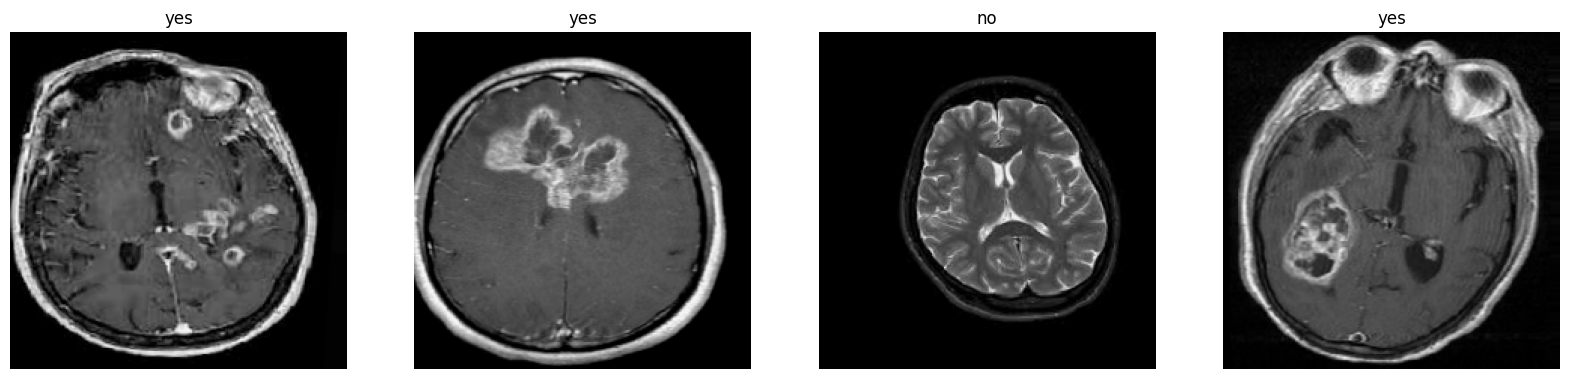

In [9]:
dic = train_gen.class_indices
classes = list(dic.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 10))

for i in range(len(images)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    index = int(labels[i])
    class_name = classes[index]
    plt.title(class_name)
    plt.axis('off')

plt.show()


In [23]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

model = Sequential([
    base_model,
    BatchNormalization(),

    Flatten(),

    Dense(128,
          activation='relu',
          kernel_regularizer=regularizers.l2(0.001)
    ),

    Dropout(rate=0.4),

    Dense(128,
          activation='relu',
          kernel_regularizer=regularizers.l2(0.001)
    ),

    Dropout(rate=0.3),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,457,729 (139.08 MB)

 Trainable params: 36,400,513 (138.86 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [24]:
epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    #callbacks = [early_stop]
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 92s 670ms/step - accuracy: 0.6660 - loss: 1.5729 - val_accuracy: 0.3922 - val_loss: 24.4805
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7565 - loss: 1.2359 - val_accuracy: 0.6078 - val_loss: 1.2455
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.7978 - loss: 0.9069 - val_accuracy: 0.5098 - val_loss: 2.6455
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8414 - loss: 0.8920 - val_accuracy: 0.3922 - val_loss: 1.9003
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8298 - loss: 0.8265 - val_accuracy: 0.3725 - val_loss: 1.7765
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9405 - loss: 0.5975 - val_accuracy: 0.4118 - val_loss: 3.5440
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.8883 - loss: 0.7689 - val_accuracy: 0.3725 - val_loss: 1.4044
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9188 - loss: 0.6605 - val_accuracy: 0.37

In [25]:
train_score = model.evaluate(train_gen)
test_score = model.evaluate(test_gen)

print("Train Accuracy: ", train_score[1])
print("Test Accuracy: ", test_score[1])

51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 1.0000 - loss: 0.3526
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9117 - loss: 0.8229
Train Accuracy:  1.0
Test Accuracy:  0.9215686321258545


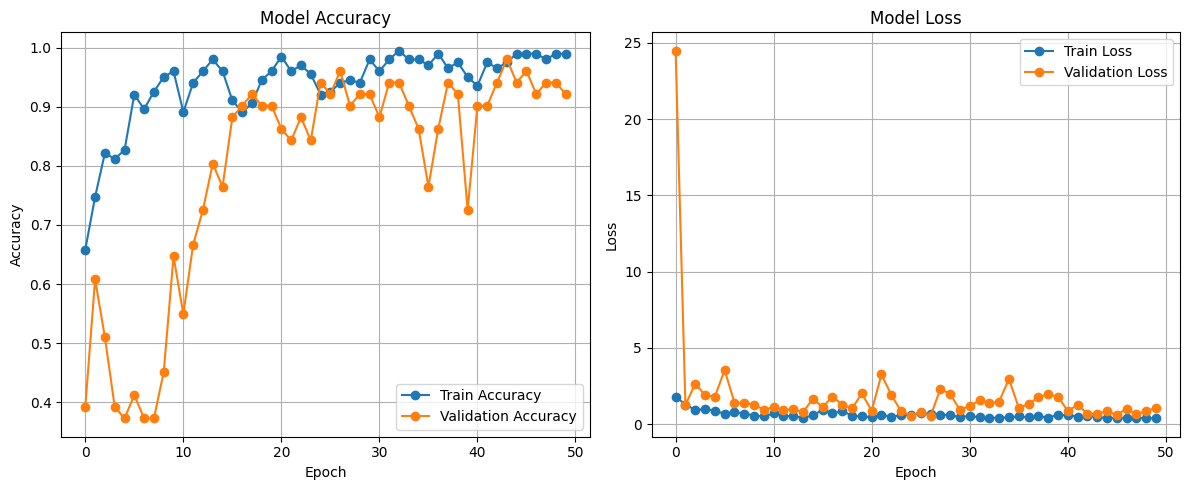

In [26]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
pred = model.predict(test_gen)
y_preds = (pred > 0.5).astype(int).flatten()
y_true = test_gen.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step


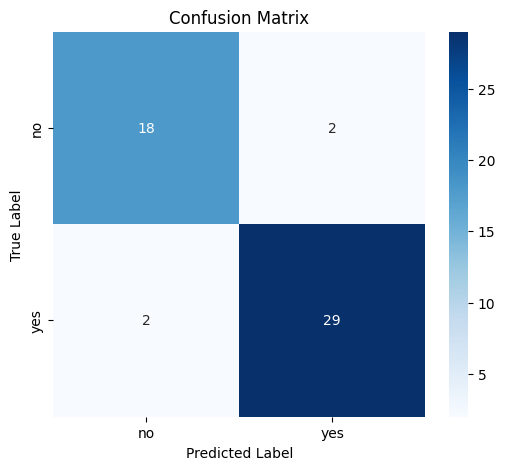

In [29]:
cm = confusion_matrix(y_true, y_preds)
labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [31]:
print("Classification Report:")
print(classification_report(y_true, y_preds, target_names=labels))

Classification Report:
              precision    recall  f1-score   support

          no       0.90      0.90      0.90        20
         yes       0.94      0.94      0.94        31

    accuracy                           0.92        51
   macro avg       0.92      0.92      0.92        51
weighted avg       0.92      0.92      0.92        51



In [33]:
model.save('Brain_Tumor_Detection.h5')